In [33]:
import numpy as np
import math
from copy import deepcopy
import sklearn.datasets
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Dataset

We import the dataset from Hastie & Tibshirani book. 
This is an artificially generated binary classification problem. Labels are in the set $\{-1,+1\}$.

In [3]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]

# Adaboost implementation

Here we implement the Adaboost algorith. We shall assume that:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $n=|X|=|y|$.

In [43]:
class AdaBoost:
    def __init__(self, weakModel, T):
        self.weakModel = weakModel
        self.T = T
        self.classifiers = []
        self.alphas = []
        self.weak_learner_errors = []
        self.ensemble_errors = []

    def trainWeakModel(self, X, y, w):
        result = deepcopy(self.weakModel)
        result.fit(X, y, sample_weight=w)
        return result

    def weightedError(self, y, y_, w):
        return np.sum(w[y != y_])

    def fit(self, X, y, print_step=10):
        n = len(y)
        w = np.ones(n) / n
        ensemble_predictions = np.zeros(n)
        for t in range(self.T):
            mt = self.trainWeakModel(X, y, w)
            y_ = mt.predict(X)
            et = self.weightedError(y, y_, w)
            if et > 0.5:
                raise ValueError("The weak model did not provide et < 0.5")
            at = 0.5 * math.log((1 - et) / et)
            self.classifiers.append(mt)
            self.alphas.append(at)
            w = w * np.exp(-at * y * y_)
            w = w / np.sum(w)
            ensemble_predictions += at * y_
            ensemble_error = np.sum(np.sign(ensemble_predictions) != y) / n
            self.ensemble_errors.append(ensemble_error)
            self.weak_learner_errors.append(et)
            if t % print_step == 0:
                print(f'Step: {t} - et: {et:.4f} - ensemble error: {ensemble_error:.4f}')
        return self

    def predict(self, X):
        return np.sign(np.sum([at * mt.predict(X) for at, mt in zip(self.alphas, self.classifiers)], axis=0))

# Testing with an SVM

Let us now see how our iplementation of AdaBoost performs on the dataset we loaded above. In this experiment we want the weak learning algorithm $\mathcal{A}$ to be good, but not too much. An SVM with a polynomial kernel of degre 3 works fine for our needs.

The SVC implementation provided by sklearn does not work well when weights are normalized. The following code simply "denormalize" weights befor calling into SVC implementation.

In [8]:
class SVC_:
    def __init__(self, kernel="rbf", degree="3"):
        self.svc = SVC(kernel=kernel, degree=degree)

    def fit(self, X,y,sample_weight=None):
        if sample_weight is not None:
            sample_weight = sample_weight * len(X)

        self.svc.fit(X,y,sample_weight=sample_weight)
        return self

    def predict(self, X):
        return self.svc.predict(X)

In [50]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 30).fit(X_train, y_train)
y_train_ = adaboost.predict(X_train)
y_test_ = adaboost.predict(X_test)

Step: 0 - et: 0.3459 - ensemble error: 0.3459
Step: 10 - et: 0.3801 - ensemble error: 0.2144
Step: 20 - et: 0.4044 - ensemble error: 0.1780


In [56]:
svc_accuracy = np.sum(y_test == y_test_) / len(y_test)
print(f'Accuracy of SVC on test set: {svc_accuracy:.4f}')

Accuracy of SVC on test set: 0.8077


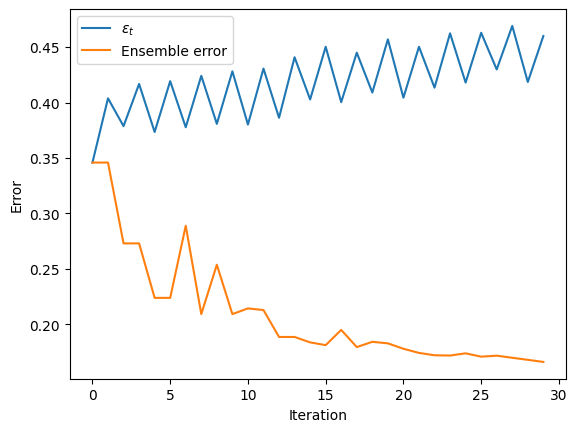

In [34]:
plt.plot(adaboost.weak_learner_errors, label="$\epsilon_t$")
plt.plot(adaboost.ensemble_errors, label="Ensemble error")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.legend()
plt.show()

# Testing on the weakest of the weak learners

We now want to experiment with a VERY weak learner. The weak learner works as follows:

- it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random; each weight shall be sampled from U(-1,1);
- it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$
- at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$ it predicts -1 otherwise.

In [41]:
class RandomLinearModel:
    def loss(self, y, y_, w):
        return np.sum(w[y != y_])
        
    def fit(self,X,y,sample_weight=None):
        self.col_weight = (np.random.rand(X.shape[1]) - 0.5) * 2
        y_ = self.predict(X)
        if self.loss(y, y_, sample_weight) > 0.5:
            self.col_weight = -self.col_weight
        return self

    def predict(self,X):
        return np.sign(X @ self.col_weight)

Let us now learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble. Evaluate the training and test error of the final ensemble model.

In [57]:
rs = RandomLinearModel()
a = AdaBoost(rs,30000).fit(X_train, y_train, print_step=1000)
y_train_ = a.predict(X_train)
y_test_ = a.predict(X_test)

Step: 0 - et: 0.4940 - ensemble error: 0.4940
Step: 1000 - et: 0.4967 - ensemble error: 0.4037
Step: 2000 - et: 0.4965 - ensemble error: 0.3645
Step: 3000 - et: 0.4945 - ensemble error: 0.3309
Step: 4000 - et: 0.4967 - ensemble error: 0.3084
Step: 5000 - et: 0.4968 - ensemble error: 0.2890
Step: 6000 - et: 0.4992 - ensemble error: 0.2675
Step: 7000 - et: 0.4927 - ensemble error: 0.2510
Step: 8000 - et: 0.4980 - ensemble error: 0.2344
Step: 9000 - et: 0.4976 - ensemble error: 0.2184
Step: 10000 - et: 0.4972 - ensemble error: 0.1994
Step: 11000 - et: 0.4997 - ensemble error: 0.1865
Step: 12000 - et: 0.4981 - ensemble error: 0.1800
Step: 13000 - et: 0.4996 - ensemble error: 0.1639
Step: 14000 - et: 0.4994 - ensemble error: 0.1524
Step: 15000 - et: 0.4964 - ensemble error: 0.1467
Step: 16000 - et: 0.4992 - ensemble error: 0.1371
Step: 17000 - et: 0.4982 - ensemble error: 0.1237
Step: 18000 - et: 0.4974 - ensemble error: 0.1165
Step: 19000 - et: 0.4994 - ensemble error: 0.1099
Step: 20000 -

In [58]:
r1_accuracy = np.sum(y_test == y_test_) / len(y_test)
print(f'Accuracy of RandomLinearModel on test set: {r1_accuracy:.4f}')

Accuracy of RandomLinearModel on test set: 0.4923


In [59]:
r2_accuracy = np.sum(y_train == y_train_) / len(y_train)
print(f'Accuracy of RandomLinearModel on train set: {r2_accuracy:.4f}')

Accuracy of RandomLinearModel on train set: 0.9623


Questo perchè AdaBoost garantisce che l'errore diminuisca sul training set, ma non fa nulla per garantire che l'errore sul test set diminuisca. In questo caso, l'errore sul test set è molto più alto di quello sul training set.

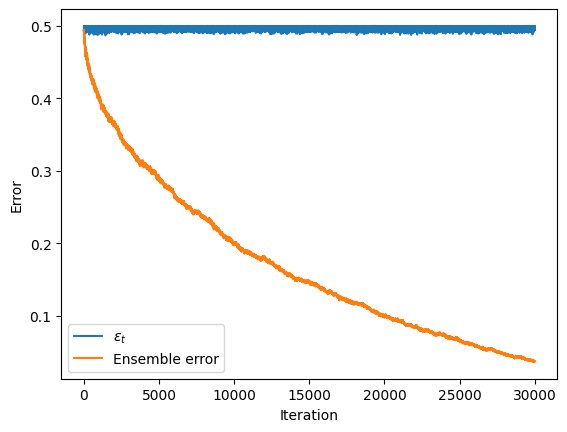

In [60]:
plt.plot(a.weak_learner_errors, label="$\epsilon_t$")
plt.plot(a.ensemble_errors, label="Ensemble error")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.legend()
plt.show()